In [2]:
### List Initialization ###

notes = []

position = []


dataset_sr = 44100

avg_centroid = 0

In [3]:
### Functions ###
import librosa
import numpy as np
from scipy.signal import find_peaks, butter, lfilter
from collections import Counter
import matplotlib.pyplot as plt


# Define the butterworth filter

def butter_lowpass_filter(data, cutoff, fs, order=6):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y


### Midi number detection ###
def midi_number_detection(audio, sr):
  global avg_centroid
  spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
  avg_centroid = np.mean(spectral_centroids)
  
  cutoff = 1500 if avg_centroid > 6000 else 200 

  filtered_data = butter_lowpass_filter(audio, cutoff, sr, order=6)

  # Compute CQT on filtered data
  cqt = np.abs(librosa.cqt(filtered_data, sr=sr))
  midi_numbers_list = []

  # Detect the peak of each time frame
  #   - cqt.shape[0]: number of frequency bins
  #   - cqt.shape[1]: number of time frames
  time_interval = len(audio) / sr / cqt.shape[1]
  t = 0
  for i in range(cqt.shape[1]):
    frame = cqt[:, i]
    peaks = find_peaks(frame, height=0.01, distance=10)[0]

    if peaks.size > 0:
      for peak in peaks:
        frequency = librosa.cqt_frequencies(n_bins=cqt.shape[0], fmin=32.7, bins_per_octave=12)[peak]

        midi_number = librosa.hz_to_midi(frequency)
        midi_numbers_list.append(midi_number)
    t += time_interval
    if t > 0.5: break
    midi_counts = Counter(midi_numbers_list)

    
  return midi_counts


def testing(dataset):
  global notes
  score = 0

  for audio_data, sr, metadata in dataset:
    # Extract the pitch from the metadata
    midi = metadata['midi']
    s = metadata['string']
    f = metadata['fret']
    # Append a tuple of the audio array, sample rate, and pitch dictionary to the signal list
    notes.append((audio_data, midi, sr))
    position.append((s, f))


  for i in range(len(notes)):
    midi = midi_number_detection(notes[i][0], 44100)
    if len(midi) == 0:
        continue
    m = round(midi.most_common(1)[0][0])
    if m == notes[i][1] or fret_list[i] > 7:
      score += 1

    else :
      print("Incorrect")
      print("Prediction: ", m)
      print("Expectation: ", notes[i][1], "signal: ", i)
      print("string: ", position[i][0], " fret: ", position[i][1])
      print("avg_centroid: ", avg_centroid)
      
    

  print(len(notes), "signals")
  print("Midi number:", label_list)

  print("Accuracy Rate(without filter): ", (score / len(notes)) * 100, "%")
  return score / len(notes)

  

In [4]:
import requests
import json
import librosa
import os

def load_audio_from_file(audio_path):
    """Load audio data from a local file."""
    audio_data, sr = librosa.load(audio_path, sr=None)  
    return audio_data, sr

def get_dataset(filter_by=None):
    """Fetch dataset based on metadata and optional filtering criteria."""
    cwd = os.getcwd()
    meta_path = os.path.join(cwd, '../metadata.json')
    audio_path = os.path.join(cwd, '../audio')
    with open(meta_path, 'r') as file:
        metadata = json.load(file)    
        dataset = []
        
    for item in metadata:
        if filter_by and item.get(filter_by['key']) != filter_by['value']:
            continue  # Skip items that don't match the filter criteria
        audio_file_path = os.path.join(audio_path, item['filename'])
        audio_data, sr = load_audio_from_file(audio_file_path)
        dataset.append((audio_data, sr, item))
    
    return dataset


In [5]:
dataset = get_dataset()



7
total time:  27.93800453514686


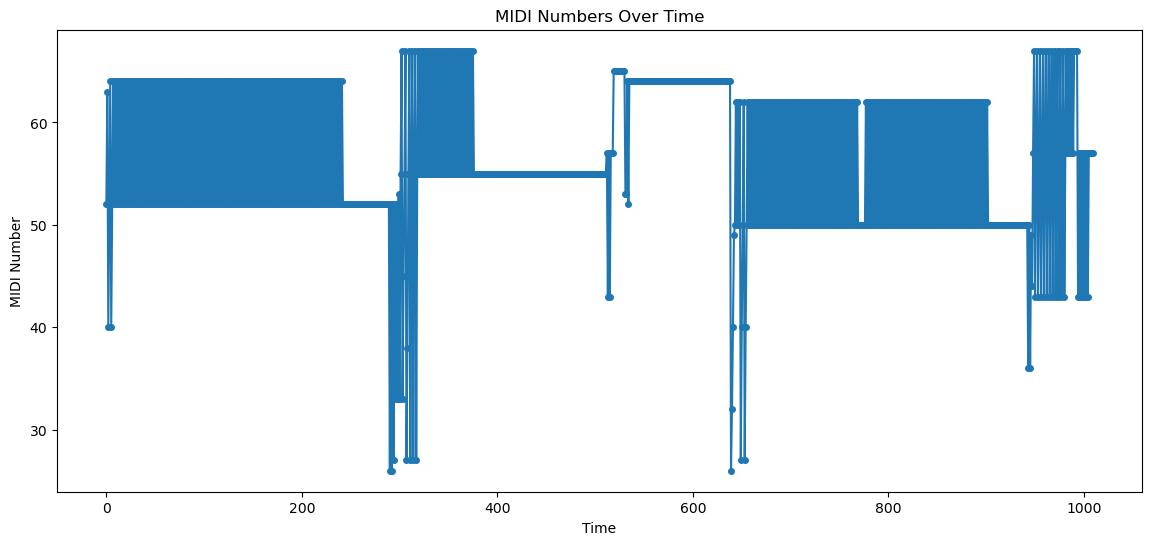

Multi MIDI List:  [52, 55, 65, 64, 50, 67, 57]


In [6]:

### Graphic ###
import librosa
import numpy as np
from scipy.signal import butter, lfilter, find_peaks
from collections import Counter
import matplotlib.pyplot as plt

# Define the butterworth filter
def butter_lowpass(cutoff, fs, order=6):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=6):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y



### dataset ###
# Depends on which audio source you choose
# audio = signal_list[80]
# sr = dataset_sr
midi_numbers_list = []
multi_midi = []
overall_list = []
bpm = 15
total_time = 0

def testing(duration):
  audio, sr = librosa.load("../audio/test8.wav")
  spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
  avg_centroid = np.mean(spectral_centroids)
  cutoff = 1500 if avg_centroid > 6000 else 200 

  filtered_data = butter_lowpass_filter(audio, cutoff, sr, order=6)

  # Compute CQT on filtered data
  cqt = np.abs(librosa.cqt(filtered_data, sr=sr))
  global midi_numbers_list
  global overall_list
  global total_time
  result = []
  
  t = 0
  j = 0
  # Detect the peak of each time frame
  time_interval = len(audio) / sr / cqt.shape[1]
  for i in range(cqt.shape[1]):
    frame = cqt[:, i]

    peaks = find_peaks(frame, height=0.01, distance=10)[0]
    if peaks.size > 0:
      for peak in peaks:
        frequency = librosa.cqt_frequencies(n_bins=cqt.shape[0], fmin=32.7, bins_per_octave=12)[peak]

        midi_number = librosa.hz_to_midi(frequency)
        midi_numbers_list.append(midi_number)
        overall_list.append(midi_number)
    t += time_interval
    total_time += time_interval
    # if i == range(cqt.shape[1])[-1]:
      # print("last midi list: ", midi_numbers_list)
    if t >= duration or i == range(cqt.shape[1])[-1]:
      # print("t", j, ": ", t)
      j +=1
      result.append(midi_numbers_list)
      t = 0
      
      midi_numbers_list = []

  return result

r = testing(60/bpm)
print(len(r))
print("total time: ", total_time)

for i in r:
  if i:
    
    midi_counts = Counter(i)
    
    most_common_midi = midi_counts.most_common(1)[0][0]
    multi_midi.append(round(most_common_midi))



# Illustate the midi numbers
plt.figure(figsize=(14, 6))
plt.plot(overall_list, marker='o', linestyle='-', markersize=4)
plt.ylabel('MIDI Number')
plt.xlabel('Time')
plt.title('MIDI Numbers Over Time')
plt.show()

# Overall Result
print("Multi MIDI List: ", multi_midi)


In [7]:
# Play the note from dataset
from IPython.display import Audio
audio, sr = librosa.load("../audio/test8.wav")
audio_file= Audio(data=audio, rate=sr)
audio_file


last peaks:  [28]


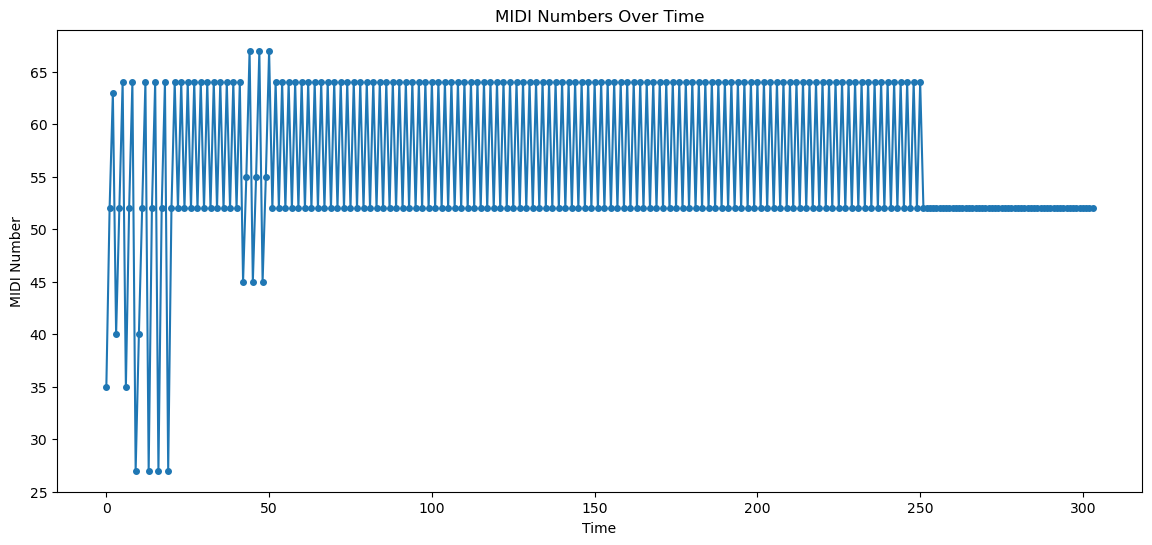

MIDI:  51.99830820503272


In [8]:

### Graphic ###
import librosa
import numpy as np
from scipy.signal import butter, lfilter, find_peaks
from collections import Counter
import matplotlib.pyplot as plt

# Define the butterworth filter
def butter_lowpass(cutoff, fs, order=6):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=6):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y



### dataset ###
# Depends on which audio source you choose
# audio = signal_list[80]
# sr = dataset_sr
midi_numbers_list = []
multi_midi = []
overall_list = []
bpm = 12
total_time = 0

def testing():
  audio, sr = librosa.load("../audio/mixed1.wav")
  spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
  avg_centroid = np.mean(spectral_centroids)
  cutoff = 1500 if avg_centroid > 6000 else 200 

  filtered_data = butter_lowpass_filter(audio, cutoff, sr, order=6)

  # Compute CQT on filtered data
  cqt = np.abs(librosa.cqt(filtered_data, sr=sr))
  global midi_numbers_list
  global overall_list
  global total_time
  result = []
  
  t = 0
  # Detect the peak of each time frame
  for i in range(cqt.shape[1]):
    frame = cqt[:, i]

    peaks = find_peaks(frame, height=0.01, distance=10)[0]
    if i == range(cqt.shape[1])[-1]:
      print("last peaks: ", peaks)
    if peaks.size > 0:
      for peak in peaks:
        frequency = librosa.cqt_frequencies(n_bins=cqt.shape[0], fmin=32.7, bins_per_octave=12)[peak]

        midi_number = librosa.hz_to_midi(frequency)
        midi_numbers_list.append(midi_number)
        overall_list.append(midi_number)


  return result

r = testing()


# Illustate the midi numbers
plt.figure(figsize=(14, 6))
plt.plot(overall_list, marker='o', linestyle='-', markersize=4)
plt.ylabel('MIDI Number')
plt.xlabel('Time')
plt.title('MIDI Numbers Over Time')
plt.show()

# Overall Result
midi_counts = Counter(overall_list)

most_common_midi = midi_counts.most_common(1)[0][0]
print("MIDI: ", most_common_midi)